In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from IPython.display import Image, display
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
def get_img_array(img_paths, size):
    img = keras.utils.load_img(img_paths, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path, alpha=0.6, sigma=1, output_size=(400, 400)):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    heatmap = cv2.GaussianBlur(heatmap, (sigma, sigma), 0)

    jet = cm.get_cmap("viridis")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = alpha * jet_heatmap + (1 - alpha) * img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    superimposed_img = superimposed_img.resize(output_size)

    superimposed_img.save(cam_path)

    display(Image(cam_path))

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
from tensorflow.keras.layers import *

In [ ]:
# Define the channel attention mechanism
class ChannelAttention(Layer):
    def __init__(self):
        super(ChannelAttention, self).__init__()

    def build(self, input_shape):
        self.global_avg_pooling = GlobalAveragePooling2D()
        self.dense_1 = Dense(units=input_shape[-1] // 2, activation='relu')
        self.dense_2 = Dense(units=input_shape[-1], activation='sigmoid')
        super(ChannelAttention, self).build(input_shape)

    def call(self, x):
        avg_pool = self.global_avg_pooling(x)
        avg_pool = Reshape((1, 1, avg_pool.shape[-1]))(avg_pool)
        avg_pool = self.dense_1(avg_pool)
        avg_pool = self.dense_2(avg_pool)
        return Multiply()([x, avg_pool])

In [ ]:
# Create a Sequential model
model = Sequential()

# Add Conv2D layers followed by channel attention mechanisms
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(ChannelAttention())  # First channel attention
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(ChannelAttention())  # Second channel attention
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4))  # Remove activation function here

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 channel_attention_4 (Chann  (None, 254, 254, 32)      1072      
 elAttention)                                                    
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 channel_attention_5 (Chann  (None, 125, 125, 64)      4192      
 elAttention)                                                    
                                                      

<ipython-input-26-a141dcb8ceb0>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("viridis")


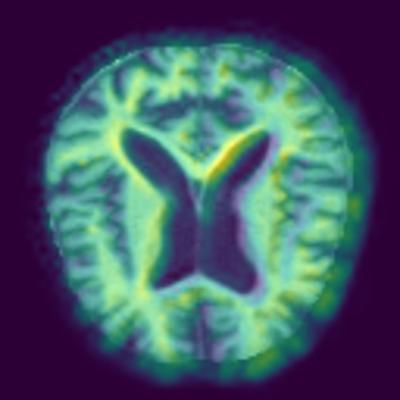

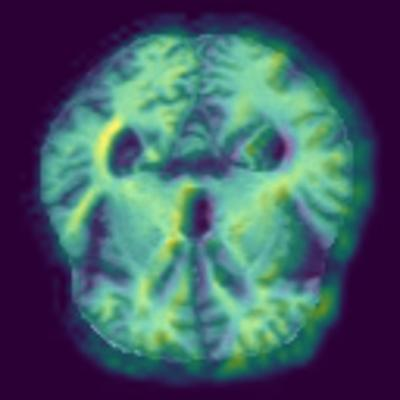

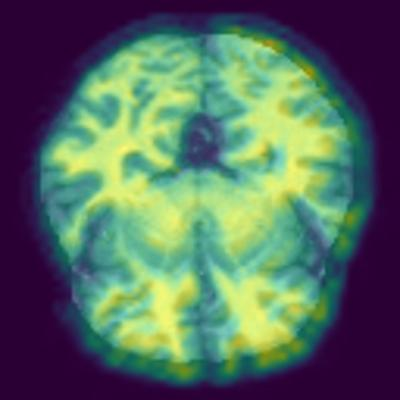

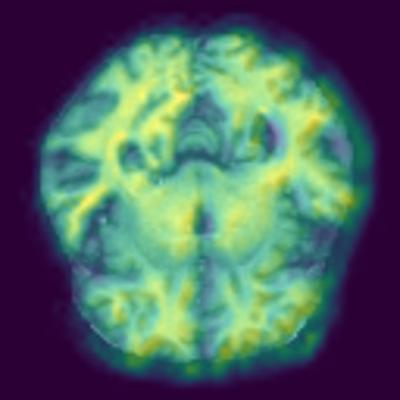

In [ ]:
# List of image paths for 4 different classes
image_paths = [
    '/content/drive/MyDrive/Alz_multi_balanced/test/Moderate Impairment/22 (2).jpg',
    '/content/drive/MyDrive/Alz_multi_balanced/test/Mild Impairment/1 (2).jpg',
    '/content/drive/MyDrive/Alz_multi_balanced/test/No Impairment/1 (28).jpg',
    '/content/drive/MyDrive/Alz_multi_balanced/test/Very Mild Impairment/1 (41).jpg',
]

img_size = (256, 256)

# Loop through each image path and generate Grad-CAM heatmap
for i, img_path in enumerate(image_paths):
    img_array = get_img_array(img_path, size=img_size)

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, "conv2d_10")

    # Save and display Grad-CAM
    save_and_display_gradcam(img_path, heatmap, f'cam_{i}.jpg', output_size=(400, 400))

<ipython-input-17-f0318b89255e>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


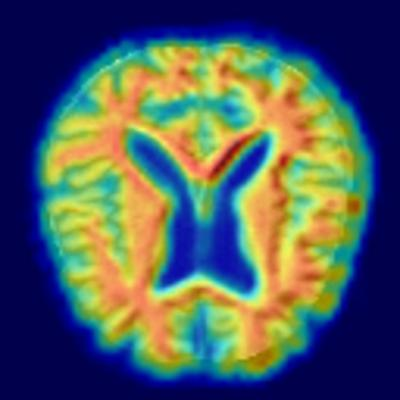

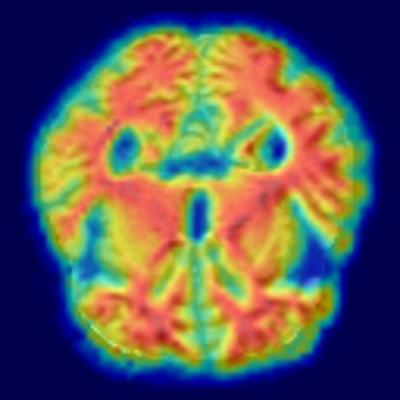

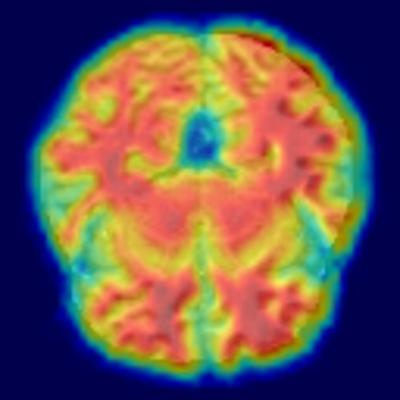

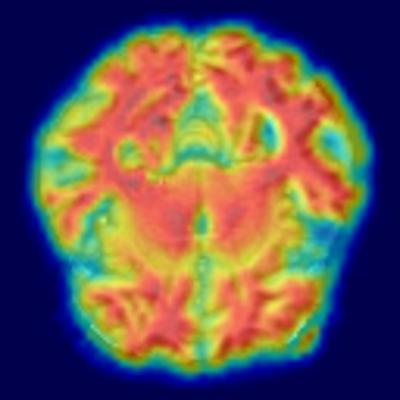

In [ ]:
# List of image paths for 4 different classes
image_paths = [
    '/content/drive/MyDrive/Alz_multi_balanced/test/Moderate Impairment/22 (2).jpg',
    '/content/drive/MyDrive/Alz_multi_balanced/test/Mild Impairment/1 (2).jpg',
    '/content/drive/MyDrive/Alz_multi_balanced/test/No Impairment/1 (28).jpg',
    '/content/drive/MyDrive/Alz_multi_balanced/test/Very Mild Impairment/1 (41).jpg',
]

img_size = (256, 256)

# Loop through each image path and generate Grad-CAM heatmap
for i, img_path in enumerate(image_paths):
    img_array = get_img_array(img_path, size=img_size)

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, "conv2d_6")

    # Save and display Grad-CAM
    save_and_display_gradcam(img_path, heatmap, f'cam_{i}.jpg', output_size=(400, 400))

<ipython-input-26-a141dcb8ceb0>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("viridis")


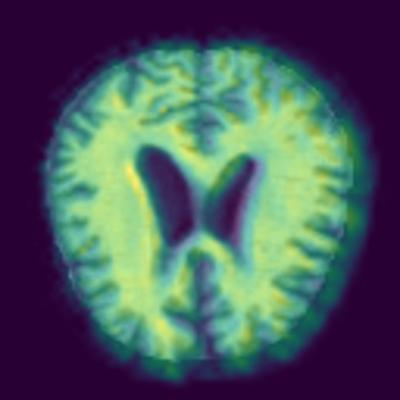

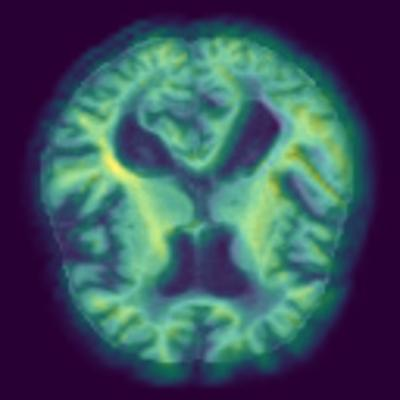

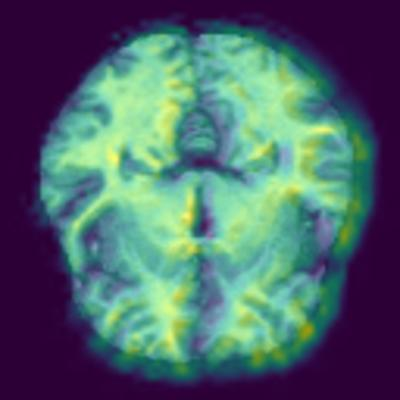

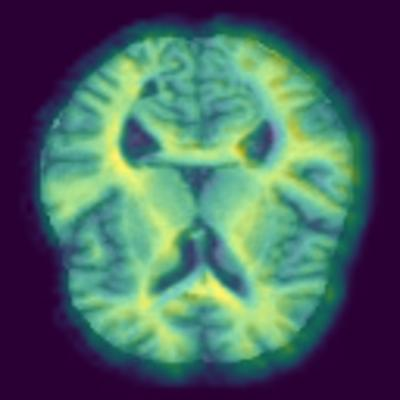

In [ ]:
# List of image paths for 4 different classes
image_paths = [
    '/content/drive/MyDrive/Alz_multi_balanced/test/Moderate Impairment/27.jpg',
    '/content/drive/MyDrive/Alz_multi_balanced/test/Mild Impairment/12 (11).jpg',
    '/content/drive/MyDrive/Alz_multi_balanced/test/No Impairment/1 (47).jpg',
    '/content/drive/MyDrive/Alz_multi_balanced/test/Very Mild Impairment/10 (20).jpg',
]

img_size = (256, 256)

# Loop through each image path and generate Grad-CAM heatmap
for i, img_path in enumerate(image_paths):
    img_array = get_img_array(img_path, size=img_size)

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, "conv2d_10")

    # Save and display Grad-CAM
    save_and_display_gradcam(img_path, heatmap, f'cam_{i}.jpg', output_size=(400, 400))

<ipython-input-17-f0318b89255e>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


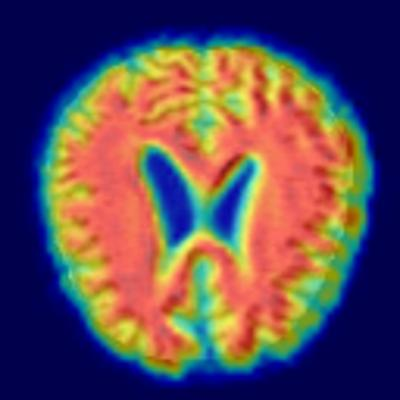

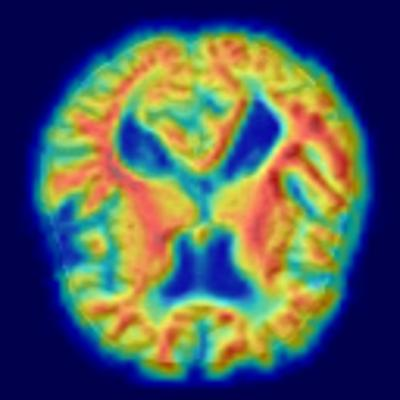

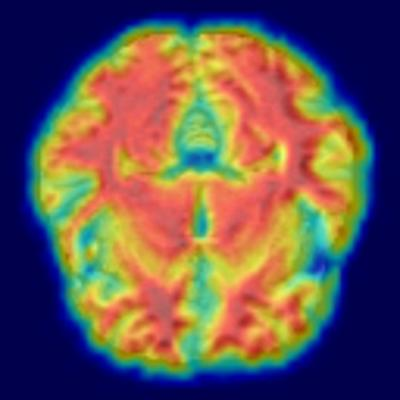

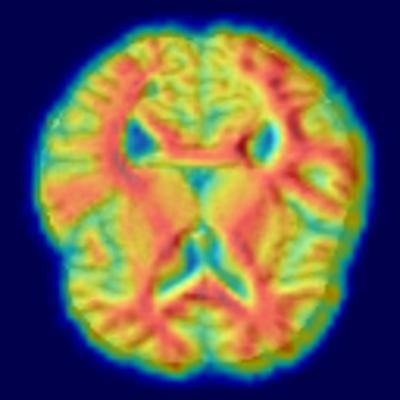

In [ ]:
# List of image paths for 4 different classes
image_paths = [
    '/content/drive/MyDrive/Alz_multi_balanced/test/Moderate Impairment/27.jpg',
    '/content/drive/MyDrive/Alz_multi_balanced/test/Mild Impairment/12 (11).jpg',
    '/content/drive/MyDrive/Alz_multi_balanced/test/No Impairment/1 (47).jpg',
    '/content/drive/MyDrive/Alz_multi_balanced/test/Very Mild Impairment/10 (20).jpg',
]

img_size = (256, 256)

# Loop through each image path and generate Grad-CAM heatmap
for i, img_path in enumerate(image_paths):
    img_array = get_img_array(img_path, size=img_size)

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, "conv2d_6")

    # Save and display Grad-CAM
    save_and_display_gradcam(img_path, heatmap, f'cam_{i}.jpg', output_size=(400, 400))

<ipython-input-26-a141dcb8ceb0>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("viridis")


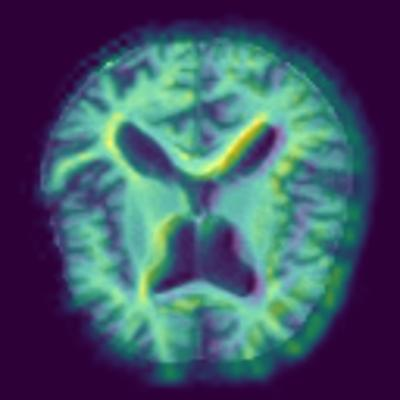

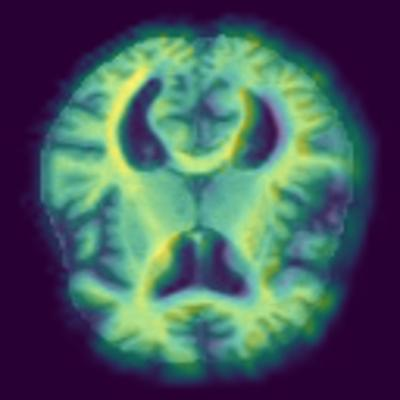

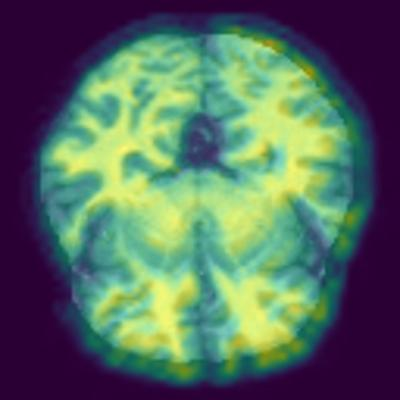

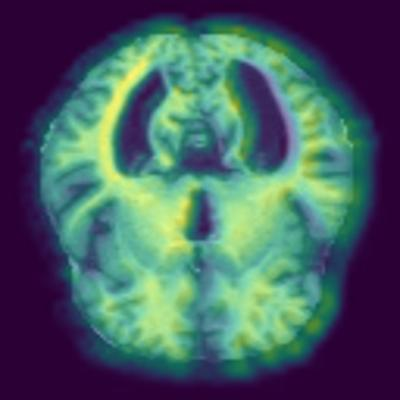

In [ ]:
# List of image paths for 4 different classes
image_paths = [
    '/content/drive/MyDrive/Alz_multi_balanced/test/Moderate Impairment/17 (2).jpg',
    '/content/drive/MyDrive/Alz_multi_balanced/test/Mild Impairment/11 (10).jpg',
    '/content/drive/MyDrive/Alz_multi_balanced/test/No Impairment/1 (28).jpg',
    '/content/drive/MyDrive/Alz_multi_balanced/test/Very Mild Impairment/1 (2).jpg',
]

img_size = (256, 256)

# Loop through each image path and generate Grad-CAM heatmap
for i, img_path in enumerate(image_paths):
    img_array = get_img_array(img_path, size=img_size)

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, "conv2d_10")

    # Save and display Grad-CAM
    save_and_display_gradcam(img_path, heatmap, f'cam_{i}.jpg', output_size=(400, 400))

<ipython-input-17-f0318b89255e>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


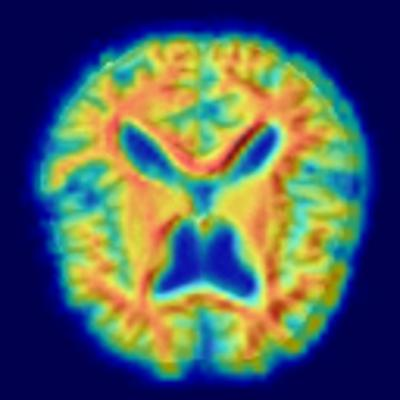

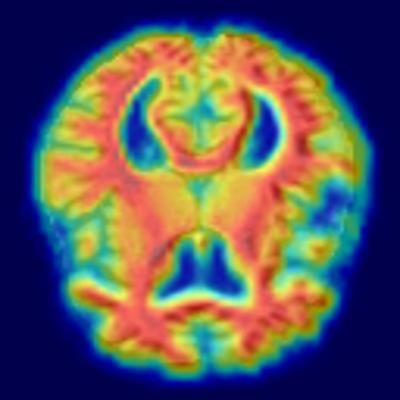

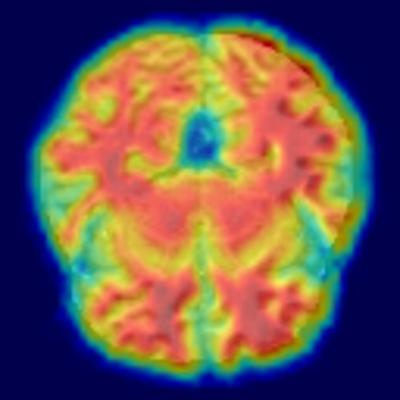

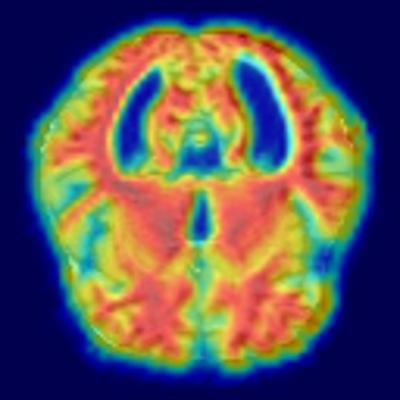

In [ ]:
# List of image paths for 4 different classes
image_paths = [
    '/content/drive/MyDrive/Alz_multi_balanced/test/Moderate Impairment/17 (2).jpg',
    '/content/drive/MyDrive/Alz_multi_balanced/test/Mild Impairment/11 (10).jpg',
    '/content/drive/MyDrive/Alz_multi_balanced/test/No Impairment/1 (28).jpg',
    '/content/drive/MyDrive/Alz_multi_balanced/test/Very Mild Impairment/1 (2).jpg',
]

img_size = (256, 256)

# Loop through each image path and generate Grad-CAM heatmap
for i, img_path in enumerate(image_paths):
    img_array = get_img_array(img_path, size=img_size)

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, "conv2d_6")

    # Save and display Grad-CAM
    save_and_display_gradcam(img_path, heatmap, f'cam_{i}.jpg', output_size=(400, 400))